In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import csv
import datetime

from networkx import group_closeness_centrality
from networkx import group_betweenness_centrality

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #ez hogy a rákban nem a defaultja a jupyternek?

# saját függvényeink
from functions import *

In [2]:
monthly_bipartite = acquireSplitData()
projected_graph = listMEPs()

In [3]:
months = []
for month in monthly_bipartite:
    nxgraph = nx.from_pandas_edgelist(month, source='AmendmentID', target='MEPName')
    meps = pd.unique(month['MEPName'])
    #print(nx.algorithms.bipartite.projected_graph(nxgraph, meps).nodes)
    months.append(nx.algorithms.bipartite.weighted_projected_graph(nxgraph, meps))

In [4]:
print(months[0].edges.data("weight", default=0))


[('César LUENA', 'Cristina MAESTRE MARTÍN DE ALMAGRO', 2), ('César LUENA', 'Javi LÓPEZ', 2), ('César LUENA', 'Nicolás GONZÁLEZ CASARES', 2), ('Cristina MAESTRE MARTÍN DE ALMAGRO', 'Javi LÓPEZ', 2), ('Cristina MAESTRE MARTÍN DE ALMAGRO', 'Nicolás GONZÁLEZ CASARES', 2), ('Javi LÓPEZ', 'Nicolás GONZÁLEZ CASARES', 2), ('Carlo FIDANZA', 'Eugen JURZYCA', 3), ('Carlo FIDANZA', 'Adam BIELAN', 3), ('Carlo FIDANZA', 'Beata MAZUREK', 3), ('Carlo FIDANZA', 'Evžen TOŠENOVSKÝ', 1), ('Eugen JURZYCA', 'Adam BIELAN', 4), ('Eugen JURZYCA', 'Beata MAZUREK', 4), ('Eugen JURZYCA', 'Evžen TOŠENOVSKÝ', 2), ('Adam BIELAN', 'Beata MAZUREK', 4), ('Adam BIELAN', 'Evžen TOŠENOVSKÝ', 2), ('Beata MAZUREK', 'Evžen TOŠENOVSKÝ', 2), ('Dita CHARANZOVÁ', 'Svenja HAHN', 1), ('Anna BONFRISCO', 'Hélène LAPORTE', 4), ('Anna BONFRISCO', 'Matteo ADINOLFI', 1), ('Anna BONFRISCO', 'Isabella ADINOLFI', 3), ('Anna BONFRISCO', 'Valentino GRANT', 4), ('Anna BONFRISCO', 'Annalisa TARDINO', 4), ('Anna BONFRISCO', 'Joachim KUHS', 4), 

This calculates simultaneously 4 different group centrality measures on the groups of Parties:

In [5]:
monthly_closeness_centality_by_party = []
#monthly_weighted_closeness_centality_by_party = []
monthly_betweenness_centality_by_party = []
#monthly_weighted_betweenness_centality_by_party = []
for month in months:
    curr_cls = {}
    #curr_w_cls = {}
    curr_btw = {}
    #curr_w_btw = {}
    monthly_meps = set(projected_graph) & set(pd.unique(month.nodes))
    for party in listPoliticalGroups():
        partymeps = set(listMEPs_by_polgroup(party)) & monthly_meps
        if partymeps == set():
            curr_cls[party] = 0
            curr_btw[party] = 0
        else:
            curr_cls[party] = group_closeness_centrality(month, partymeps, weight=None)
            #curr_w_cls[party] = group_closeness_centrality(month, partymeps, weight=month.edges.data("weight", default=0) )
            curr_btw[party] = group_betweenness_centrality(month, partymeps, weight=None)
            #curr_w_btw[party] = group_betweenness_centrality(month, partymeps, weight=month.edges.data("weight", default=0))
            
    monthly_closeness_centality_by_party.append(curr_cls)
    #monthly_weighted_closeness_centality_by_party.append(curr_w_cls)
    monthly_betweenness_centality_by_party.append(curr_btw)
    #monthly_weighted_betweenness_centality_by_party.append(curr_w_btw)
    
monthly_closeness_centality_by_party = pd.DataFrame(monthly_closeness_centality_by_party)
#monthly_weighted_closeness_centality_by_party = pd.DataFrame(monthly_weighted_closeness_centality_by_party)
monthly_betweenness_centality_by_party = pd.DataFrame(monthly_betweenness_centality_by_party)
#monthly_weighted_betweenness_centality_by_party = pd.DataFrame(monthly_weighted_betweenness_centality_by_party)
#print(monthly_closeness_centality_by_party)

Nincs értelme a weighted és a sime közt különbséget tenni

In [6]:
#print(monthly_weighted_betweenness_centality_by_party == monthly_betweenness_centality_by_party)

In [7]:
monthly_closeness_centality_by_country = []
monthly_betweenness_centality_by_country = []
for month in months:
    curr_cls = {}
    curr_btw = {}
    monthly_meps = set(projected_graph) & set(pd.unique(month.nodes))
    for country in listCountries():
        countrymeps = set(listMEPs_by_country(country)) & monthly_meps
        if countrymeps == set():
            curr_cls[country] = 0
            curr_btw[country] = 0
        else:
            curr_cls[country] = group_closeness_centrality(month, countrymeps, weight=None)
            curr_btw[country] = group_betweenness_centrality(month, countrymeps, weight=None)
            
    monthly_closeness_centality_by_country.append(curr_cls)
    monthly_betweenness_centality_by_country.append(curr_btw)
    
monthly_closeness_centality_by_country = pd.DataFrame(monthly_closeness_centality_by_country)
monthly_betweenness_centality_by_country = pd.DataFrame(monthly_betweenness_centality_by_country)

In [8]:
def normalize_by_line(DF):
    DF = DF.transpose()
    for col in DF:
        list_col = list(DF[col])
        M = max(list_col)
        if M != 0:
            for i in range(len(list_col)):
                list_col[i] = list_col[i] / M
        else:
            continue
        DF[col] = list_col
    DF = DF.transpose()
    return DF

In [9]:
normalised_closeness_county = normalize_by_line(monthly_closeness_centality_by_country)
normalised_betweenness_county = normalize_by_line(monthly_betweenness_centality_by_country)
normalised_closeness_party = normalize_by_line(monthly_closeness_centality_by_party)
normalised_betweenness_party = normalize_by_line(monthly_betweenness_centality_by_party)

In [10]:
normalised_closeness_party.to_csv("results/monthly_closeness_by_party.csv")
normalised_betweenness_party.to_csv("results/monthly_betweenness_by_party.csv")
normalised_closeness_county.to_csv("results/monthly_closeness_by_country.csv")
normalised_betweenness_county.to_csv("results/monthly_betweenness_by_country.csv")

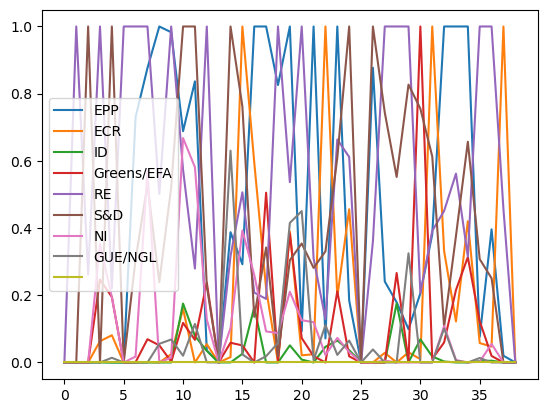

In [11]:
normalised_betweenness_party.plot()
plt.show()
#ennek így nincs értelme, vagy az abszolút maxal normálok, vagy nem normálok

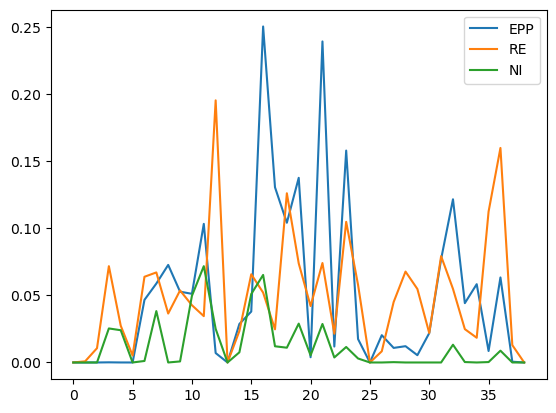

In [12]:
monthly_betweenness_centality_by_party[["EPP", "RE", "NI"]].plot()
plt.show()

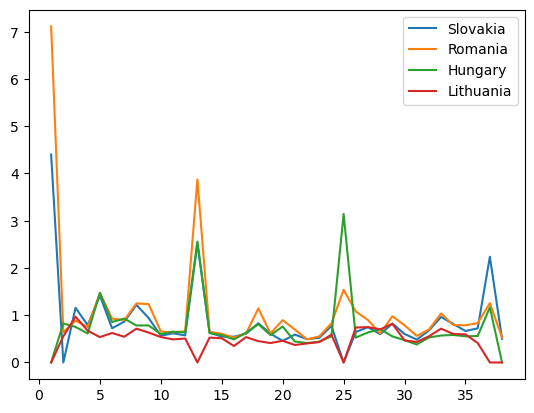

In [44]:
monthly_closeness_centality_by_country[[ "Slovakia", "Romania", "Hungary", "Lithuania"]][1:].plot()
plt.show()
#Erdwekes listak: [["Germany", "Belgium", "France", "Italy", "Poland"]]
#[["Germany", "Belgium", "France"]]
# Kelet Europa: [["Czechia", "Poland", "Slovakia", "Romania", "Hungary", "Lithuania", "Estonia", "Latvia"]]

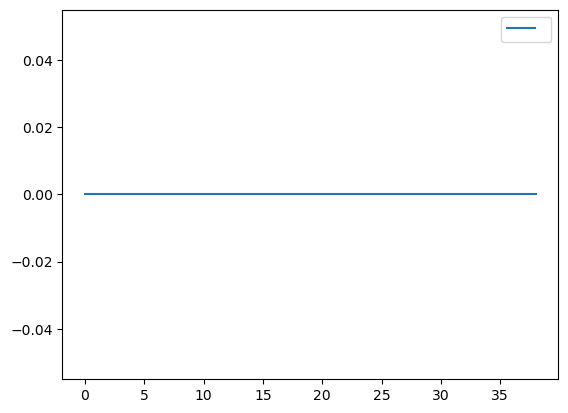

In [63]:
monthly_closeness_centality_by_party[[""]].plot()
plt.show()

Lets calculate the 1/Standard Devation of these numbers 

In [78]:
monthly_closeness_centality_by_party["NI"]

0      8.875000
1      2.423077
2     26.571429
3      0.863071
4      0.740845
5     57.500000
6     12.000000
7      0.696970
8     35.000000
9      0.547872
10     0.554264
11     0.554230
12     0.629389
13     8.428571
14     0.448217
15     0.552350
16     0.665192
17     0.520231
18     0.596091
19     0.642948
20     0.401074
21     0.435993
22     0.310493
23     0.528993
24     0.330870
25     0.000000
26     0.455971
27    14.464286
28     0.548161
29     0.410020
30     0.325476
31     0.356863
32     0.598224
33     0.620536
34     0.424505
35     0.416066
36     0.333639
37     1.031250
38     0.000000
Name: NI, dtype: float64

In [79]:
sd_closeness_centrality_party = []
for idoszak in range(len(monthly_closeness_centality_by_party["EPP"])):
    sd = []
    for party in monthly_closeness_centality_by_party:
        if party != "":
            sd.append(monthly_closeness_centality_by_party[party][idoszak])
    if np.std(sd) != 0:
        sd_closeness_centrality_party.append(1/np.std(sd))
    else: 
        sd_closeness_centrality_party.append(1/256)

In [80]:
print(sd_closeness_centrality_party)

[0.052439307793425524, 0.05094201892906725, 0.03426222211938081, 0.015578391891257185, 5.6678623981638525, 0.02582066597335452, 0.02166348272148089, 0.00962757069370073, 0.056127423427863164, 5.0052219353440615, 16.217056679090373, 9.879590117684467, 12.566337249885708, 0.35874594048333436, 0.012026242864030343, 11.438447001055541, 6.7947213802580055, 8.027944596258433, 4.544307177124814, 9.785998755163602, 0.6389708865409801, 12.768782176342086, 10.21956912872814, 14.89100851911946, 6.778562423299789, 0.00390625, 5.144170169800809, 0.007901652156697931, 13.92658537602474, 0.03264549712194062, 8.663871451204123, 23.378183621938287, 8.425096973349302, 5.59136644737263, 6.675158068605545, 9.174370179608077, 5.772240432225488, 0.02715648553697462, 2.9972824611385067]


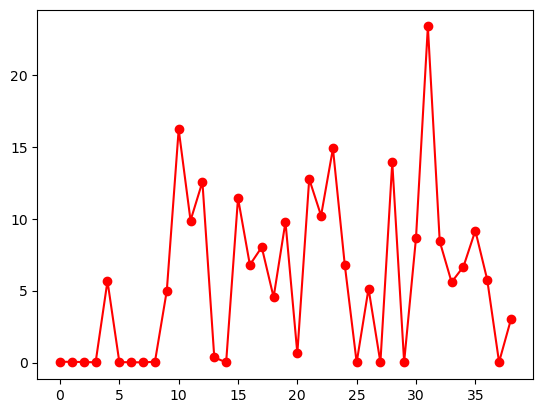

In [84]:
plt.plot(list(sd_closeness_centrality_party), "o-r")
plt.show()

In [103]:
sd_closeness_centrality_country = []
for idoszak in range(len(monthly_closeness_centality_by_country["Hungary"])):
    sd = []
    for country in monthly_closeness_centality_by_country:
        if country != "":
            sd.append(monthly_closeness_centality_by_country[country][idoszak])
    if np.std(sd) != 0:
        sd_closeness_centrality_country.append(1/np.std(sd))
    else: 
        sd_closeness_centrality_country.append(1/188)

In [104]:
print(sd_closeness_centrality_country)

[0.06061806984212291, 0.07384831116820866, 0.3402714156595266, 0.09815283666432235, 4.611804321895345, 0.02247986209318087, 4.317450329157095, 0.5799099087506026, 0.14978571360417542, 3.3299555551445152, 7.294043721011823, 6.383579494725384, 6.570962173088151, 0.051731462027312825, 6.6837216261444325, 7.016471441466076, 5.615895745715498, 5.54082771752991, 4.63459441870169, 6.552037246947789, 5.479446956990421, 6.516425449441238, 6.01855463423853, 6.994320081636131, 5.740119938254261, 0.6409892969508008, 4.4841345914553905, 4.759552500903146, 5.575164753149594, 0.012883667644355758, 5.549901943590265, 7.034246508211751, 5.8216455961473, 4.429063596850569, 5.425363923029954, 5.200563330808132, 4.644585093700728, 0.07308547991453374, 2.702939853350562]


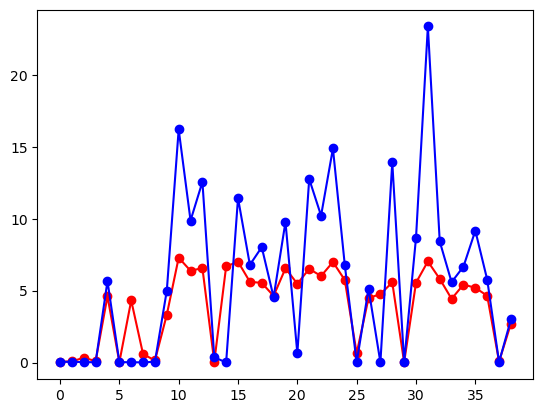

In [106]:
plt.plot(list(sd_closeness_centrality_country), "o-r")
plt.plot(list(sd_closeness_centrality_party), "o-b")
plt.show()